### Walkthrough example of preprocessing a worm dataset (`Kato2015`) 
---

This notebook aims to introduce the Kato2015 dataset from the paper titled Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans by Kato et al.

We will provide a detailed overview of how the raw data is organized and preprocessed. Although slight modifications may be required for other datasets, the overall methodology remains consistent.

*Last updated: 10 July 2023*

In [23]:
import matplotlib.pyplot as plt
import mat73
import numpy as np
import os
import seaborn as sns
import subprocess
import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.data import download_url

from preprocess._utils import (
    interpolate_data,
    reshape_calcium_data,
    smooth_data_preprocess,
)
from utils import NEURONS_302, ROOT_DIR

In [24]:
# set numpy random seed
np.random.seed(42)

# download Kato2015 dataset
url = "https://www.dropbox.com/s/5r5cyxoads3iglz/opensource_data.zip?dl=1"
zipfile = "opensource_data.zip"
zip_path = os.path.join(ROOT_DIR, zipfile)
source_path = os.path.join(ROOT_DIR, zipfile.strip(".zip"))

if not os.path.exists(source_path):
    download_url(url=url, folder=ROOT_DIR, filename=zipfile)
    # unzip the Kato2015 folder
    bash_command = [
        "unzip",
        zip_path,
        "{}/*".format("Kato2015"),
        "-d",
        source_path,
    ]
    std_out = subprocess.run(bash_command, text=True)  # Run the bash command
    print(std_out, end="\n\n")
    # delete the zip file
    os.unlink(zip_path)
else:
    print("Kato2015 dataset already downloaded and unzipped.")

DATA_DIR = os.path.join(source_path, "Kato2015")

Archive:  /Users/quileesimeon/GitHub Repos/worm-graph/opensource_data.zip
   creating: /Users/quileesimeon/GitHub Repos/worm-graph/opensource_data/Kato2015/
  inflating: /Users/quileesimeon/GitHub Repos/worm-graph/opensource_data/Kato2015/WT_Stim.mat  
  inflating: /Users/quileesimeon/GitHub Repos/worm-graph/opensource_data/Kato2015/.DS_Store  
  inflating: /Users/quileesimeon/GitHub Repos/worm-graph/opensource_data/Kato2015/WT_NoStim.mat  
  inflating: /Users/quileesimeon/GitHub Repos/worm-graph/opensource_data/Kato2015/readme_Kato2015.txt  
CompletedProcess(args=['unzip', '/Users/quileesimeon/GitHub Repos/worm-graph/opensource_data.zip', 'Kato2015/*', '-d', '/Users/quileesimeon/GitHub Repos/worm-graph/opensource_data'], returncode=0)



In [25]:
# Function to print n elements of a list
def print_list(l, n):
    for i in range(n):
        print(l[i])


# Function to pick non-none element from a list
def pick_non_none(l):
    for i in range(len(l)):
        if l[i] is not None:
            return l[i]


# Function to determine the similarity between two neurons
def neuron_similarity(neuron1, neuron2):
    neuron1 = neuron1.detach().numpy()
    neuron2 = neuron2.detach().numpy()
    return np.sum(neuron1.T @ neuron2) / (
        np.linalg.norm(neuron1) * np.linalg.norm(neuron2)
    )

In [26]:
def plot_signals(data, time_tensor, neuron_idx=None, yax_limit=True):
    assert isinstance(data, torch.Tensor), "data must be a PyTorch tensor"
    assert isinstance(time_tensor, torch.Tensor), "time_tensor must be a PyTorch tensor"
    assert data.dim() == 2, "data must be a 2D tensor"
    assert isinstance(neuron_idx, (int, list)), "neuron_idx must be an integer or list"

    time_tensor = time_tensor.squeeze()
    assert data.size(0) == time_tensor.size(
        0
    ), "Number of rows in data and time_tensor must match"

    num_neurons = data.size(1)

    # Randomly select the column indices if not provided
    if isinstance(neuron_idx, int):
        assert (
            neuron_idx <= num_neurons
        ), "neuron_idx cannot exceed the number of neurons"
        column_indices = np.random.choice(num_neurons, neuron_idx, replace=False)
    elif isinstance(neuron_idx, list):
        assert (
            len(neuron_idx) <= num_neurons
        ), "neuron_idx cannot exceed the number of neurons"
        column_indices = np.array(neuron_idx)

    num_columns = len(column_indices)

    # Extract the selected columns from the data tensor
    selected_columns = data[:, column_indices]

    # Define the color palette using scientific colors
    colors = sns.color_palette("bright", num_columns)

    # Plotting subplots vertically
    fig, axs = plt.subplots(num_columns, 1, figsize=(15, num_columns))
    fig.tight_layout(pad=0.0)

    for i, ax in enumerate(axs):
        ax.plot(time_tensor, selected_columns[:, i], color=colors[i])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        if yax_limit:
            ax.set_ylim(-1.0, 1.0)
        ax.set_ylabel("Neuron {}".format(column_indices[i]))

        if i < num_columns - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel("Time")

    plt.show()

# Raw data structure
---

This dataset is splitted into two MATLAB documents: `WT_Stim.mat` and `WT_NoStim.mat`. Here is how they are structured:

* `traces_raw` = neural activity traces uncorrected
* `traces` = neural activity traces corrected for bleaching
* `tracesDif` = derivative of traces
* `IDs` = identified neuron IDs
* `timeVectorSeconds` = time vector in seconds
* `fps` = frames per second
* `dataset` = name of dataset
* `stimulus`
	* `identity` = what was changed e.g. O2 (oxygen)
	* `type` = stimulus type e.g. binary steps
	* `switchtimes` =  time in seconds when stimulus changed from initial state to the other state
	* `initialstate` = the state that the stimulus starts with, refers to "conc"
	* `conc` = the concentrations of the stimulus
	* `concunits` - units of the "conc"

`States` = vector of different state types (8 states for WT_NoStim, 4 states for `WT_Stim` and `AVA_HisCl`)

* 8 states for `WT_NoStim`:
	* ‘FWD’ forward crawling 
	* ‘SLOW’ forward slowing
	* ‘DT’ dorsal post reversal turn
	* ‘VT’ ventral post reversal turn
	* ‘REV1’ reverse crawling
	* ‘REV2’ reverse crawling
	* ‘REVSUS’ sustained reverse crawling
	* ‘NOSTATE’ - ambiguous
  
* 4 states for `WT_Stim` and `AVA_HisCl`:
	* ‘FWD’ forward crawling 
	* ‘REV’ reverse crawling
	* ‘REVSUS’ sustained reverse crawling
	* ‘TURN’ post reversal turn

# Processing the data
---

In [27]:
# Loading the data
dataset_raw = mat73.loadmat(os.path.join(DATA_DIR, "WT_Stim.mat"))[
    "WT_Stim"
]  # Return a dict
print("Raw data keys:", dataset_raw.keys(), end="\n\n")

# We will use just these features
features = ["IDs", "traces", "timeVectorSeconds"]
sizes = {}
for ft in features:
    sizes[ft] = [len(data) for data in dataset_raw[ft]]
print("The features have the following sizes:")
for ft in features:
    print(" {}: {}".format(ft, sizes[ft]))

Raw data keys: dict_keys(['IDs', 'States', 'dataset', 'fps', 'stimulus', 'timeVectorSeconds', 'traces', 'tracesDif', 'traces_raw'])

The features have the following sizes:
 IDs: [107, 122, 124, 134, 123, 151, 146]
 traces: [2198, 2017, 2197, 2018, 2201, 2017, 2019]
 timeVectorSeconds: [2198, 2017, 2197, 2018, 2201, 2017, 2019]


## Extracting neuron IDs
---

In [28]:
# Let's take a look at the IDs
print_list(dataset_raw["IDs"], 2)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, ['IL1DR', 'URYDR'], None, None, None, None, ['IL1DL', 'URYDL'], ['OLQDR', 'URYDR'], ['OLQVR', 'URYVR'], ['OLQVL', 'URYVL'], ['OLQDL', 'URYDL'], None, None, ['BAGL'], ['BAGR'], ['RMED'], ['RMEL'], None, None, ['RID'], None, None, ['RMEV'], ['ASKR'], [None, 'AFDL', 'ASKL'], ['AVAL'], None, ['ASKL', 'AFDL'], ['URXL', 'URXR'], ['ALA'], None, None, None, None, ['AVEL'], None, None, None, None, None, None, None, ['RIVL', 'AVHL', 'AVJL'], ['AIBR'], None, ['AVBL'], ['AIBL'], None, ['RIMR'], None, None, None, ['RIBL'], None, None, ['RIBR'], None, ['SMBDR', None], ['RIML'], None, None, None, None, None, None, None, None, None, None, None, ['RIS'], ['VB02'], None, ['AVFR'], ['SABVL', 'SABVR'], ['AVFL'], ['SABVR', None], ['RIFR'], None, ['VB01'], None, [None, 'RIGR'], ['SABD'], ['VA01'], ['RIGL'], None, ['SMDVL'], None, ['AVAR'], ['AVBR'], ['DB01'], ['DB02']]
[None, None, None, None, None, None, None, 

In [29]:
# Each list represents a worm. We need to extract just the neurons that are actives.
# Here we exemplify for the 5th worm.

oneID = dataset_raw["IDs"][4]
print("Raw IDs ({}): {}".format(len(oneID), oneID))
oneID = [
    (pick_non_none(j) if isinstance(j, list) else j) for j in oneID
]  # Just the first active neuron
oneID = [
    (str(_) if j is None or isinstance(j, np.ndarray) else str(j))
    for _, j in enumerate(oneID)
]  # Position on the list or name of the neuron
print("None to position ({}): {}".format(len(oneID), oneID))
_, inds = np.unique(oneID, return_index=True)  # Get unique neurons and their indices
oneID = [oneID[i] for i in inds]  # Get unique neurons
print("Unique neurons ({}): {}".format(len(oneID), oneID))

Raw IDs (123): [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, ['URYDR'], ['URYVL'], ['URYVR'], ['URADL'], ['URADR'], ['URYDL'], None, None, None, ['BAGL'], ['OLQVR'], None, None, ['OLQDL', 'URYDL'], ['OLQVL', 'URYVL'], ['OLQDR', 'URYDR'], ['BAGR'], ['RMER'], ['RMEL'], ['RMED'], None, ['RMEV'], None, None, ['RID'], None, ['AVAL'], None, ['---'], ['RMDVL'], ['---'], ['---', '---'], ['AVAR'], ['SMDVR'], ['ALA'], ['AVEL'], None, None, None, None, ['AVER'], ['URXL', 'URXR'], None, None, None, None, None, None, None, None, ['AIBL'], ['AIBR'], None, None, ['RIBL'], None, None, None, None, ['SIADR', None, '---'], None, ['AVBR'], ['AVBL'], None, None, ['RIBR'], None, None, None, None, None, ['RIMR'], ['RIVR', '---', '---'], None, None, None, None, None, ['RIML'], ['SMBDL'], None, None, None, ['SMBDR'], None, None, None, None, None, None, None, None, None, None, None, None, ['RIS'], None, None, ['VB02'], ['AVFR'], ['SABVR', 'SABVL'], ['AVFL

After extracting the labels, we obtain a list that contains the indexes of the neurons. In cases where a neuron couldn't be identified, it is assigned a numerical value. To obtain a list of unique labels, we can utilize the numpy unique function. This function allows us to filter out any repeated labels, providing us with a concise and distinct set of identified neurons for further analysis.

# Extracting the Traces
---

By utilizing the ordering of the unique neuron labels obtained from the numpy unique function, we can reorganize the columns of the calcium data. This reorganization ensures that the columns align with the specific neurons they represent, facilitating data analysis and interpretation.

In [30]:
# Using just the unique neurons, we can extract the traces
oneTrace_ = dataset_raw["traces"][4]
oneTrace_ = oneTrace_[:, inds]  # reordering columns
print("Unique traces: {}".format(oneTrace_.shape))

Unique traces: (2201, 121)


# Mapping the neurons
---

In [31]:
# Here is how we map the neurons to indices
idx_to_neuron = {
    nid: (str(nid) if (j is None or isinstance(j, np.ndarray)) else str(j))
    for nid, j in enumerate(oneID)
}

print(idx_to_neuron)

{0: '---', 1: '0', 2: '1', 3: '10', 4: '101', 5: '102', 6: '103', 7: '104', 8: '105', 9: '106', 10: '107', 11: '108', 12: '109', 13: '11', 14: '110', 15: '111', 16: '112', 17: '114', 18: '115', 19: '12', 20: '13', 21: '14', 22: '15', 23: '16', 24: '2', 25: '23', 26: '24', 27: '25', 28: '28', 29: '29', 30: '3', 31: '37', 32: '39', 33: '4', 34: '40', 35: '42', 36: '44', 37: '5', 38: '53', 39: '54', 40: '55', 41: '56', 42: '59', 43: '6', 44: '60', 45: '61', 46: '62', 47: '63', 48: '64', 49: '65', 50: '66', 51: '69', 52: '7', 53: '70', 54: '72', 55: '73', 56: '74', 57: '75', 58: '77', 59: '8', 60: '80', 61: '81', 62: '83', 63: '84', 64: '85', 65: '86', 66: '87', 67: '9', 68: '90', 69: '91', 70: '92', 71: '93', 72: '94', 73: '97', 74: '98', 75: '99', 76: 'AIBL', 77: 'AIBR', 78: 'ALA', 79: 'AVAL', 80: 'AVAR', 81: 'AVBL', 82: 'AVBR', 83: 'AVEL', 84: 'AVER', 85: 'AVFL', 86: 'AVFR', 87: 'BAGL', 88: 'BAGR', 89: 'DB02', 90: 'OLQDL', 91: 'OLQDR', 92: 'OLQVL', 93: 'OLQVR', 94: 'RIBL', 95: 'RIBR', 9

In [32]:
# Format the neuron names if it finishes with 0
idx_to_neuron = {
    nid: (
        name.replace("0", "")
        if not name.endswith("0") and not name.isnumeric()
        else name
    )
    for nid, name in idx_to_neuron.items()
}
print(idx_to_neuron)

{0: '---', 1: '0', 2: '1', 3: '10', 4: '101', 5: '102', 6: '103', 7: '104', 8: '105', 9: '106', 10: '107', 11: '108', 12: '109', 13: '11', 14: '110', 15: '111', 16: '112', 17: '114', 18: '115', 19: '12', 20: '13', 21: '14', 22: '15', 23: '16', 24: '2', 25: '23', 26: '24', 27: '25', 28: '28', 29: '29', 30: '3', 31: '37', 32: '39', 33: '4', 34: '40', 35: '42', 36: '44', 37: '5', 38: '53', 39: '54', 40: '55', 41: '56', 42: '59', 43: '6', 44: '60', 45: '61', 46: '62', 47: '63', 48: '64', 49: '65', 50: '66', 51: '69', 52: '7', 53: '70', 54: '72', 55: '73', 56: '74', 57: '75', 58: '77', 59: '8', 60: '80', 61: '81', 62: '83', 63: '84', 64: '85', 65: '86', 66: '87', 67: '9', 68: '90', 69: '91', 70: '92', 71: '93', 72: '94', 73: '97', 74: '98', 75: '99', 76: 'AIBL', 77: 'AIBR', 78: 'ALA', 79: 'AVAL', 80: 'AVAR', 81: 'AVBL', 82: 'AVBR', 83: 'AVEL', 84: 'AVER', 85: 'AVFL', 86: 'AVFR', 87: 'BAGL', 88: 'BAGR', 89: 'DB2', 90: 'OLQDL', 91: 'OLQDR', 92: 'OLQVL', 93: 'OLQVR', 94: 'RIBL', 95: 'RIBR', 96

Notice that even after being relatively careful, we still ended up with a neuron labelled "---". This speaks to the difficulty and importance of carefully inspecting and cleaning raw data. This nonsense label will end up being removed by the next step, which checks the neuron labels against a standardized set of neuron names for all of the 302  neurons in _C. elegans_.  

In [33]:
# Standardize the neuron ordering
idx_to_neuron = {
    nid: (str(nid) if name not in set(NEURONS_302) else name)
    for nid, name in idx_to_neuron.items()
}
print(idx_to_neuron)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 41: '41', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48', 49: '49', 50: '50', 51: '51', 52: '52', 53: '53', 54: '54', 55: '55', 56: '56', 57: '57', 58: '58', 59: '59', 60: '60', 61: '61', 62: '62', 63: '63', 64: '64', 65: '65', 66: '66', 67: '67', 68: '68', 69: '69', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: 'AIBL', 77: 'AIBR', 78: 'ALA', 79: 'AVAL', 80: 'AVAR', 81: 'AVBL', 82: 'AVBR', 83: 'AVEL', 84: 'AVER', 85: 'AVFL', 86: 'AVFR', 87: 'BAGL', 88: 'BAGR', 89: 'DB2', 90: 'OLQDL', 91: 'OLQDR', 92: 'OLQVL', 93: 'OLQVR', 94: 'RIBL', 95: 'RIBR', 96: 'RID', 97: 'R

In [34]:
# Invert the mapping
neuron_to_idx = dict((v, k) for k, v in idx_to_neuron.items())
print(neuron_to_idx)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50, '51': 51, '52': 52, '53': 53, '54': 54, '55': 55, '56': 56, '57': 57, '58': 58, '59': 59, '60': 60, '61': 61, '62': 62, '63': 63, '64': 64, '65': 65, '66': 66, '67': 67, '68': 68, '69': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, 'AIBL': 76, 'AIBR': 77, 'ALA': 78, 'AVAL': 79, 'AVAR': 80, 'AVBL': 81, 'AVBR': 82, 'AVEL': 83, 'AVER': 84, 'AVFL': 85, 'AVFR': 86, 'BAGL': 87, 'BAGR': 88, 'DB2': 89, 'OLQDL': 90, 'OLQDR': 91, 'OLQVL': 92, 'OLQVR': 93, 'RIBL': 94, 'RIBR': 95, 'RID': 96, 'RIGR'

In [35]:
num_named_neurons = len(
    [k for k in neuron_to_idx.keys() if not k.isnumeric()]
)  # number of neurons that were labeled with a name
print("Number of named neurons:", num_named_neurons)

Number of named neurons: 45


# Extracting time vector
---

In [36]:
# Reshape it to a column vector
oneTime = dataset_raw["timeVectorSeconds"][4]
oneTime = oneTime.reshape(-1, 1)
print("Time vector: {}".format(oneTime.shape))

Time vector: (2201, 1)


# Transforming data
---

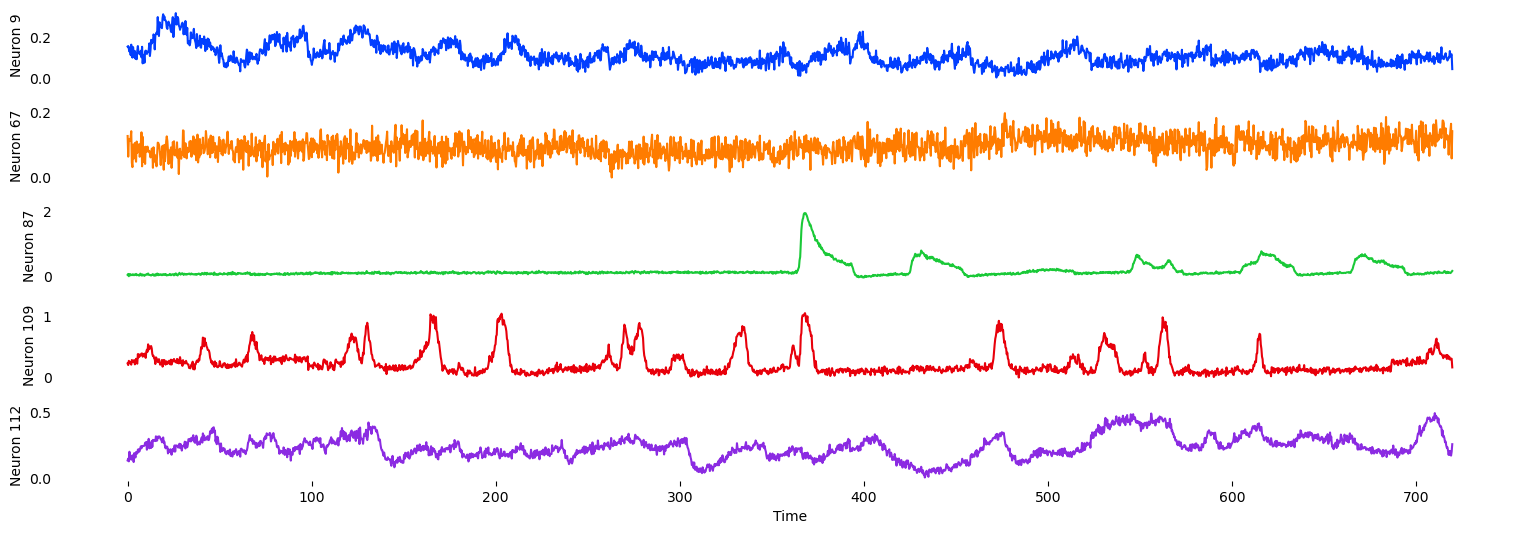

In [37]:
# Let's plot the raw traces
plot_signals(
    torch.from_numpy(oneTrace_),
    torch.from_numpy(oneTime),
    [9, 67, 87, 109, 112],
    yax_limit=False,
)

In [38]:
# We can choose to normalize the traces in the time dimension or in the feature dimension
transform = StandardScaler()
oneTrace_norm_ft = transform.fit_transform(
    oneTrace_
)  # Normalize in the feature dimension
oneTime = torch.from_numpy(oneTime).float()
oneTrace = torch.from_numpy(oneTrace_norm_ft).float()

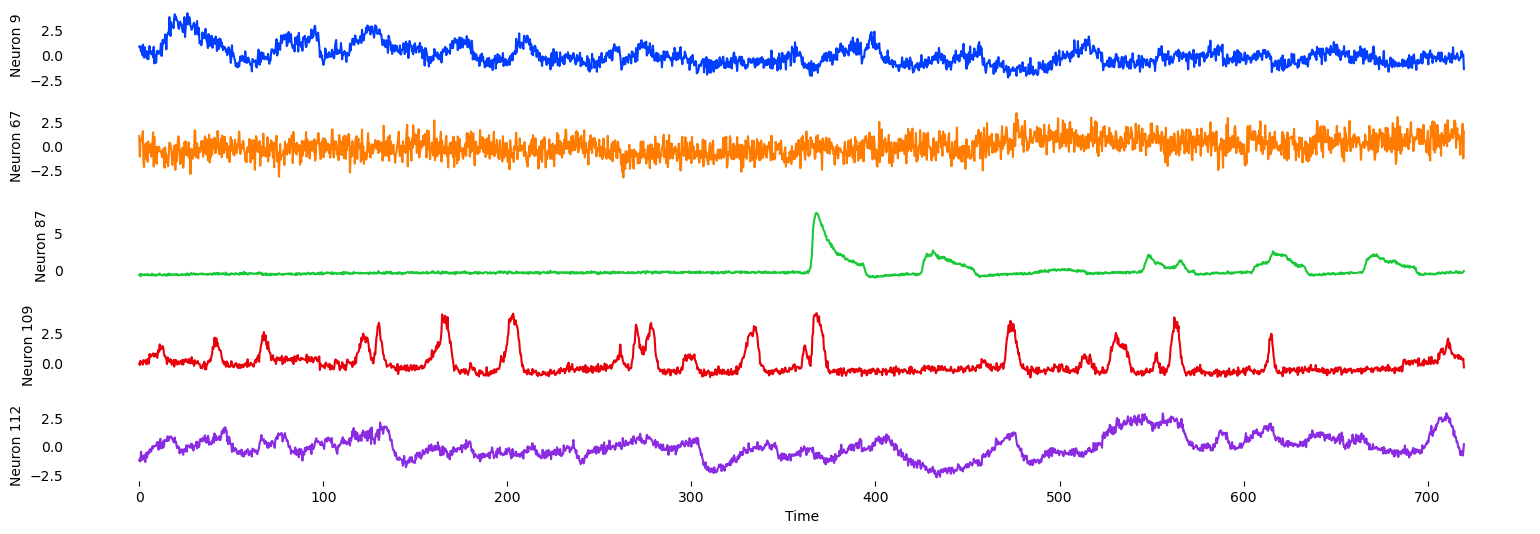

In [39]:
# Let's plot the normalized traces
plot_signals(
    oneTrace,
    oneTime,
    [9, 67, 87, 109, 112],
    yax_limit=False,
)

# Resampling and Smoothing the data
---

In [40]:
# We create a vector containing the time steps
dt = np.gradient(oneTime, axis=0)
dt[dt == 0] = np.finfo(
    float
).eps  # assigning a very small positive value to any element equal to zero.
original_median_dt = np.median(dt).item()

In [41]:
# Calculating the residual calcium (derivative of the calcium in time)
residual_calcium = np.gradient(oneTrace, axis=0) / dt

Time step difference: [0.1 0.1 0.1 ... 0.1 0.1 0.1]


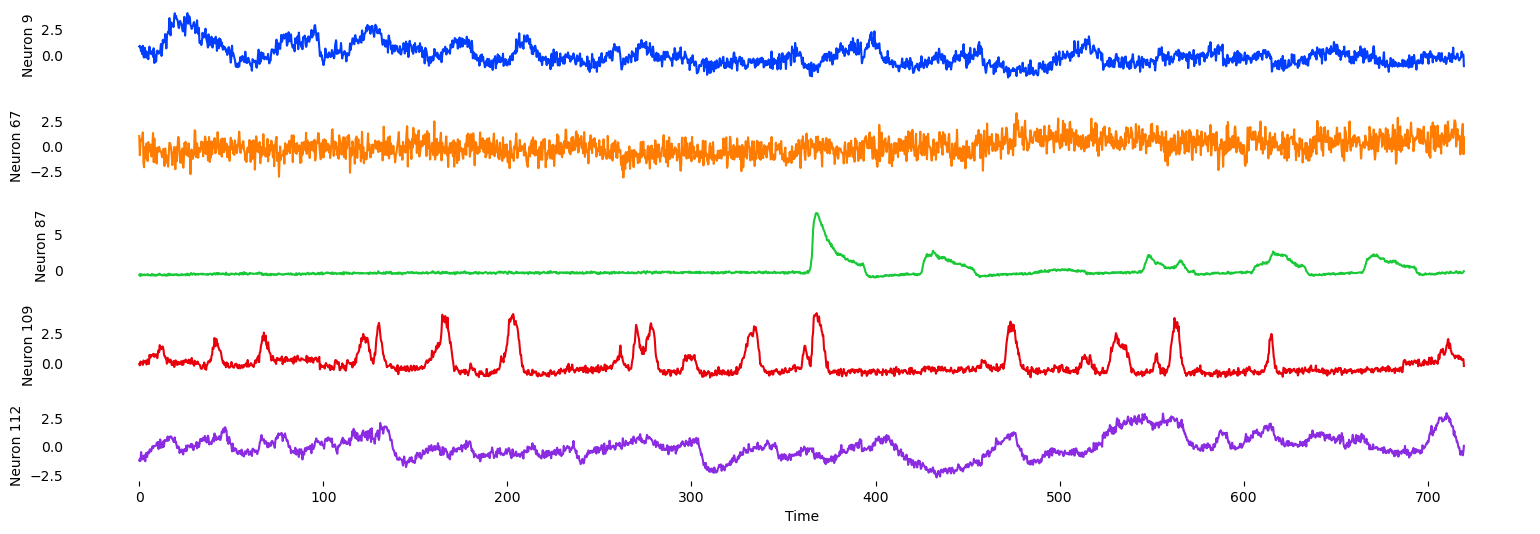

Time vector: (7197,)
Unique traces: (7197, 121)


In [42]:
# We resample the signal to a fixed time step
resample_median_dt = 0.10
oneTime_interp, oneTrace_interp = interpolate_data(
    oneTime, oneTrace, target_dt=resample_median_dt
)

# Print difference between consecutive time steps of interpolated oneTime
print("Time step difference: {}".format(np.diff(oneTime_interp.flatten())))

# Let's plot the resampled traces
plot_signals(
    torch.from_numpy(oneTrace_interp),
    torch.from_numpy(oneTime_interp),
    [9, 67, 87, 109, 112],
    yax_limit=False,
)

print("Time vector: {}".format(oneTime_interp.shape))
print("Unique traces: {}".format(oneTrace_interp.shape))

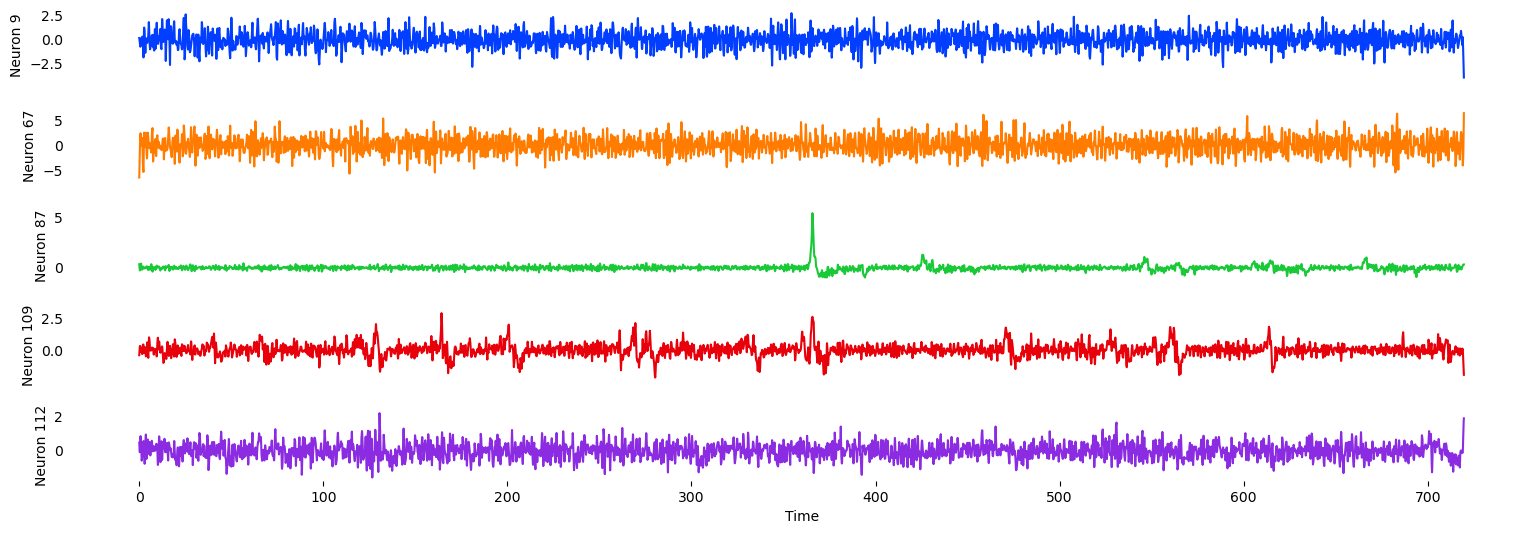

Resampled residual calcium shape: (7197, 121)


In [43]:
# Resample the residual calcium
_, residual_calcium_interp = interpolate_data(
    oneTime, residual_calcium, target_dt=resample_median_dt
)
plot_signals(
    torch.from_numpy(residual_calcium_interp),
    torch.from_numpy(oneTime_interp),
    [9, 67, 87, 109, 112],
    yax_limit=False,
)
print("Resampled residual calcium shape: {}".format(residual_calcium_interp.shape))

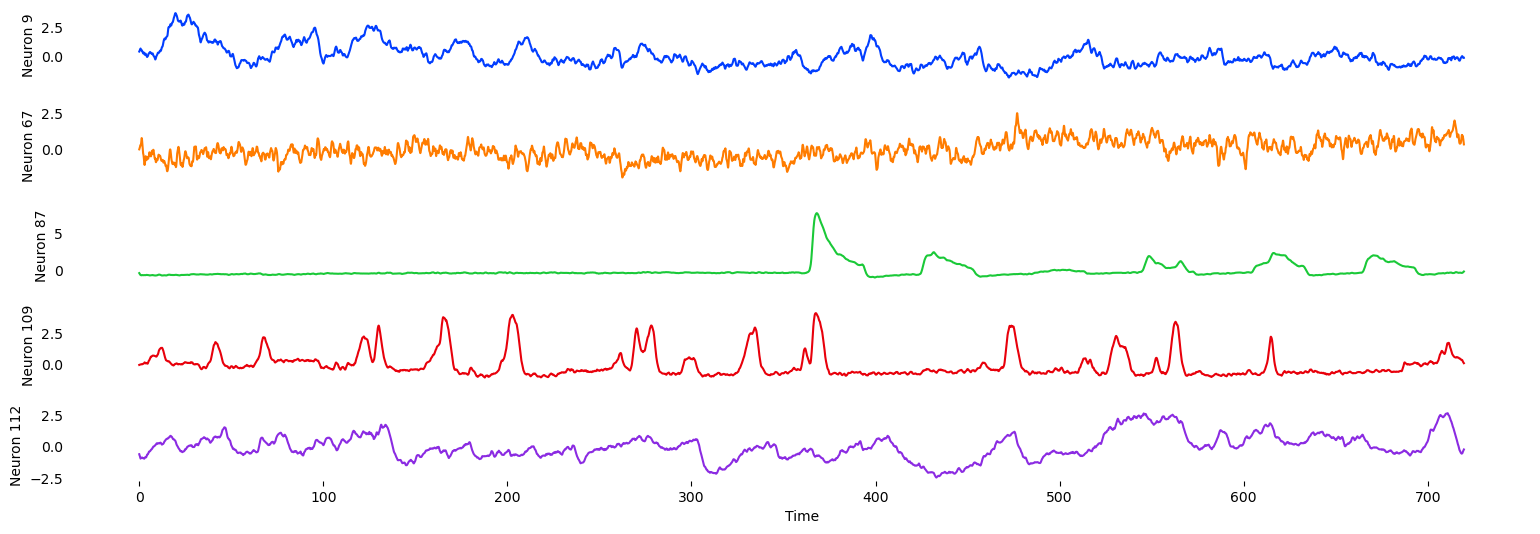

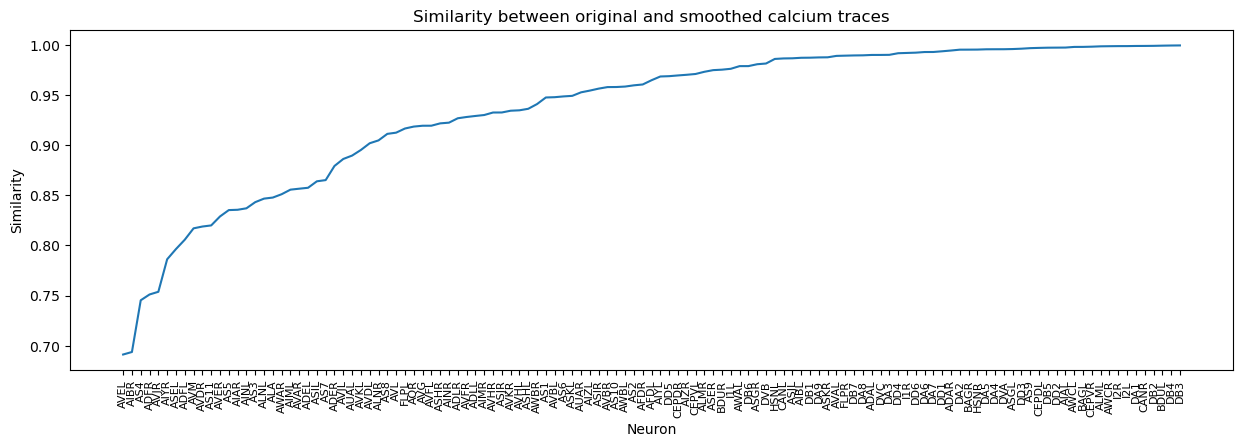

In [44]:
# Now, we smooth the data using the FFT method
oneTrace_smooth = smooth_data_preprocess(
    oneTrace_interp,
    time_in_seconds=oneTime_interp,
    smooth_method="ma",
)

# Let's plot the smoothed traces
plot_signals(
    torch.from_numpy(oneTrace_smooth),
    torch.from_numpy(oneTime_interp),
    [9, 67, 87, 109, 112],
    yax_limit=False,
)

# Let's see the similarity between the neurons (columns)
sim = []
for n in range(oneTrace_smooth.shape[1]):
    sim.append(
        neuron_similarity(
            torch.from_numpy(oneTrace_smooth[:, n]),
            torch.from_numpy(oneTrace_interp[:, n]),
        )
    )
sorted_sim, indices = np.sort(sim), np.argsort(sim)
sorted_neurons = np.array(NEURONS_302)[indices]

# Let's plot the similarity between the neurons
plt.figure(figsize=(15, 5))
plt.plot(sorted_neurons, sorted_sim)
plt.xticks(rotation=90, fontsize=8)
plt.subplots_adjust(bottom=0.2)
plt.title("Similarity between original and smoothed calcium traces")
plt.xlabel("Neuron")
plt.ylabel("Similarity")
plt.show()


In [45]:
# Same for the residual calcium
residual_calcium_smooth = smooth_data_preprocess(
    residual_calcium_interp,
    time_in_seconds=oneTime_interp,
    smooth_method="ma",
)


# Saving the data
---

In [46]:
# Finally we need to reshape the data to a standard format
# First we save all the data inside a data dict to pass to the function

oneDict = {}

oneDict.update(
    {
        "worm0": {
            "dataset": "Kato2015",
            "smooth_method": "FFT",
            "worm": "worm0",
            "calcium_data": oneTrace_interp,
            "smooth_calcium_data": oneTrace_smooth,
            "residual_calcium": residual_calcium_interp,
            "smooth_residual_calcium": residual_calcium_smooth,
            "neuron_to_idx": neuron_to_idx,
            "idx_to_neuron": dict((v, k) for k, v in neuron_to_idx.items()),
            "max_timesteps": oneTrace_interp.shape[0],
            "time_in_seconds": oneTime_interp,
            "original_median_dt": original_median_dt,
            "resample_median_dt": resample_median_dt,
            "dt": dt,
            "num_neurons": oneTrace_interp.shape[1],  # labeled + unlabeled
            "num_named_neurons": num_named_neurons,  # labeled
            "num_unknown_neurons": oneTrace_interp.shape[1]
            - num_named_neurons,  # unlabeled
        },
    }
)

In [47]:
# Now we can call the function to reshape the data  to a standard format
oneDict_std = reshape_calcium_data(oneDict["worm0"])

# Here are the keys of the final dict
for key in sorted(oneDict_std.keys()):
    print(key)

calcium_data
dataset
dt
max_timesteps
named_neuron_to_slot
named_neurons_mask
neuron_to_slot
neurons_mask
num_named_neurons
num_neurons
num_unknown_neurons
original_median_dt
resample_median_dt
residual_calcium
slot_to_named_neuron
slot_to_neuron
slot_to_unknown_neuron
smooth_calcium_data
smooth_method
smooth_residual_calcium
time_in_seconds
unknown_neuron_to_slot
unknown_neurons_mask
worm


In [48]:
for key in oneDict_std.keys():
    if type(oneDict_std[key]) is str:
        print("{}: {}".format(key, oneDict_std[key]))
    elif (type(oneDict_std[key]) is float) or (type(oneDict_std[key]) is int):
        print("{}: {}".format(key, oneDict_std[key]))
    elif type(oneDict_std[key]) is dict:
        print("{}: {}".format(key, len(oneDict_std[key])))
    else:
        print("{}: {}".format(key, oneDict_std[key].shape))

dataset: Kato2015
smooth_method: FFT
worm: worm0
calcium_data: torch.Size([7197, 302])
smooth_calcium_data: torch.Size([7197, 302])
residual_calcium: torch.Size([7197, 302])
smooth_residual_calcium: torch.Size([7197, 302])
max_timesteps: 7197
time_in_seconds: torch.Size([7197, 1])
original_median_dt: 0.3271217346191406
resample_median_dt: 0.1
dt: torch.Size([7197, 1])
num_neurons: 121
num_named_neurons: 45
num_unknown_neurons: 76
named_neurons_mask: torch.Size([302])
unknown_neurons_mask: torch.Size([302])
neurons_mask: torch.Size([302])
slot_to_named_neuron: 45
named_neuron_to_slot: 45
slot_to_unknown_neuron: 76
unknown_neuron_to_slot: 76
slot_to_neuron: 121
neuron_to_slot: 121


Now that the data is ready for use! Here is a description of each element within the dataset:

* `calcium_data`: (torch.tensor) The calcium data, with standardized columns. Shape: (max_timesteps, 302)
* `dataset`: (str) Name of the dataset
* `dt`: (float) Difference between time steps
* `max_timesteps`: (float) Number of time steps of the data
* `named_neuron_to_slot`: (dict) Mapping of 302 neurons -> column index. Len: `num_neurons`
* `named_neurons_mask`: (torch.tensor) A bool vector indicating the positions of the labeled neurons. Shape: (302)
* `neuron_to_slot`: (dict) Mapping of labeled+unlabeled neurons -> column index. Len: `num_neurons`
* `neurons_mask`: (torch.tensor) A bool vector indication the positions of all tracked neurons (labeled + unlabeled). Shape: (302)
* `num_named_neurons`: (int) Number of labeled neurons
* `num_neurons`: (int) Number of total tracked neurons of this specific worm
* `num_unknown_neurons`: (int) Number of unlabeled neurons
* `original_median_dt`: The median `dt` of the original time series before being resampled. 
* `resample_median_dt`: The constant `dt` after them time series is interpolated and resampled.
* `residual_calcium`: (torch.tensor) The residual calcium data, with standardized columns. Shape: (max_timesteps, 302)
* `smooth_calcium_data`: (torch.tensor) Smoothed calcium data, with standardized columns. Shape: (max_timesteps, 302)
* `smooth_method`: (str) Method used to smooth the calcium data
* `smooth_residual_calcium`: (torch.tensor) Smoothed residual calcium data, with standardized columns. Shape: (max_timesteps, 302)
* `slot_to_named_neuron`: (dict) Mapping of column index -> 302 neurons. Len: `num_neurons`
* `slot_to_neuron`: (dict) Mapping of column intex -> labeled+unlabeled neurons. Len: `num_neurons`
* `slot_to_unknown_neuron`: (dict) Mapping of column index -> unlabeled neuron. Len: `num_unknown_neurons`
* `time_in_seconds`: (torch.tensor) A column vector equally spaced by `dt`. Shape: (`max_timesteps`, 1)
* `unknown_neuron_to_slot`: (dict) Mapping of unlabeled neurons -> column index. Len: `num_unknown_neurons`
* `unknown_neurons_mask`: (torch.tensor) A bool vector indicating the positions of the unlabeled neurons. Shape: (302)
* `worm`: (str) The worm ID in the dataset.